In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import requests 
from urllib.parse import urlencode

import scipy.stats as stats
import pingouin as pg

<!--  -->
**Проект: вариант 1**

Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.



In [2]:
# Для начала выведу данные и сохраню их

In [3]:
# Вывожу данные о дате регистрации пользователей и сохраняю их в registration
registration = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-andrejand-volkov/shared/problem1-reg_data.csv', sep = ';')

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [4]:
# Посмотрю на датасет с датами регистрации пользователей
registration.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [5]:
# Посмотрю информацию о датасете
registration.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


In [6]:
registration.shape

(1000000, 2)

In [7]:
# Выведу информацию о пропущенных значениях - их нет
registration.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [8]:
# Проверю id пользователей на уникальность - Все id в таблице registration являются уникальными
registration.uid.nunique() == registration.shape[0]

True

In [9]:
# Создам копию датафрейма registration, чтобы он не изменялся
reg_copy = registration.copy()

In [10]:
reg_copy.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [11]:
# Далее необходимо преобразовать колонку reg_ts в формат нормальной даты
reg_copy['reg_ts'] = pd.to_datetime(reg_copy['reg_ts'], unit='s').dt.to_period('D')

In [12]:
# Переименую колонку reg_ts в registration_date для удобства
reg_copy = reg_copy.rename(columns={'reg_ts':'registration_date'})

In [13]:
# Переведу колонку uid в тип строки, чтобы python воспринимал id, как строку
reg_copy.uid = reg_copy.uid.apply(str)

In [14]:
reg_copy.head()

,registration_date,uid
0,1998-11-18,1
1,1999-07-22,2
2,2000-01-13,3
3,2000-05-28,4
4,2000-09-16,5


In [15]:
# Посмотрю теперь на преобразованный тип данных, правильно ли перевёл
reg_copy.dtypes

registration_date    period[D]
uid                     object
dtype: object

In [16]:
# Выведу информацию о датах для себя

In [17]:
reg_copy.registration_date.describe()

count        1000000
unique          5110
top       2020-09-22
freq            1641
Name: registration_date, dtype: object

In [18]:
reg_copy.registration_date.min()

Period('1998-11-18', 'D')

In [19]:
reg_copy.registration_date.max()

Period('2020-09-23', 'D')

In [20]:
# Проверю, что ничего не повредил 
reg_copy.shape[0] == registration.shape[0]

True

In [21]:
# Вывожу данные о дате захода в приложение каждого пользователя и сохраню в entering
entering = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-andrejand-volkov/shared/problem1-auth_data.csv', sep = ';')

In [22]:
# Посмотрим на второй датасет с датами захода пользователей в игру
entering.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [23]:
entering.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


In [24]:
# Выведу информацию о пропущенных значениях - их нет
entering.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [25]:
# Проверяю, что количество уникальных пользователей
# в датасете с датой захода пользователя в игру == количеству пользователей в датасете с датой их регистрации
    
entering.uid.nunique() == registration.uid.nunique()

True

In [26]:
# Создам копию датафрейма entering, чтобы он не изменялся
ent_copy = entering.copy()

In [27]:
ent_copy.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [28]:
# Далее аналогично преобразовываю колонку auth_ts в формат нормальной даты
ent_copy['auth_ts'] = pd.to_datetime(ent_copy['auth_ts'], unit='s').dt.to_period('D')

In [29]:
# Переименую колонку reg_ts в entering_date для удобства
ent_copy = ent_copy.rename(columns={'auth_ts':'entering_date'})

In [30]:
# Переведу колонку uid в тип строки
ent_copy.uid = ent_copy.uid.apply(str)

In [31]:
ent_copy.head()

,entering_date,uid
0,1998-11-18,1
1,1999-07-22,2
2,1999-07-25,2
3,1999-07-31,2
4,1999-08-05,2


In [32]:
# Посмотрю теперь на преобразованный тип данных, правильно ли перевёл
ent_copy.dtypes

entering_date    period[D]
uid                 object
dtype: object

In [33]:
# Выведу информацию о датах для себя

In [34]:
ent_copy.entering_date.describe()

count        9601013
unique          6169
top       2020-09-21
freq           15948
Name: entering_date, dtype: object

In [35]:
ent_copy.entering_date.min()

Period('1998-11-18', 'D')

In [36]:
ent_copy.entering_date.max()

Period('2020-09-23', 'D')

In [37]:
# Проверяю, что ничего не сломал
ent_copy.shape[0] == entering.shape[0]

True

**Задание 1**

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

In [38]:
def retention(registration_table, entering_the_game_table, date_1, date_2):
    # В функции использую:
    # registration_table - таблица с датой регистрации пользователей - reg_copy     
    # entering_the_game_table - таблица с датой захода пользователей в игру - ent_copy
    # date_1 - первая дата (дата начала периода, за который буду считать Retention)
    # date_2 - вторая дата (дата конца периода, за который буду считать Retention)
    
     
    # Фильтрую данные по нужным датам (при вызове функции смогу задавать период, например: день, месяц или год)
    df_registration = reg_copy.query('registration_date >= @date_1 and registration_date <= @date_2')
    df_entering = ent_copy.query('entering_date >= @date_1 and entering_date <= @date_2')
    
    # Соединяю две таблицы - о дате регистрации пользователей и информации о посещении ими игры
    # Мне нужны все данные из таблицы с датами захода в игру    
    df = df_entering.merge(df_registration, how='left', on='uid')
    
    # В получившимся датасете будут строки с пропущенными значениями, а именно даты, которые не попали в указанный мною период
    # Нужно их удалить    
    df_without_nan = df.dropna(axis=0, how='any')
    
    # Создам колонку с разницей дней от даты регистрации до даты захода в игру
    df_without_nan['number_of_days'] = df_without_nan.entering_date - df_without_nan.registration_date
    
    # Преобразую в числовой формат результат разницы
    df_without_nan['number_of_days'] = df_without_nan.number_of_days.apply(lambda x: x.n)
    
    # Создам когорты
    df_cohort = df_without_nan \
        .groupby(['registration_date', 'number_of_days'], as_index=False)\
        .nunique('uid')\
        .rename(columns={"uid": "counted_id"})
    
    # Сделаю сводную таблицу
    df_pivot = df_cohort.pivot(index='registration_date', columns='number_of_days', values='counted_id')
    
    # Посчитаю retention для каждой когорты
    # Делю каждое число в строке на число пользователей, которые зарегистрировались в нулевой день    
    df_retention = df_pivot.divide(df_pivot[0], axis=0)
    
    # Создам колонку с данными о размере каждой когорты (число пользователей, зарегистрировавшихся в нулевой день)
    df_retention.insert(0, "cohort_size", df_pivot[0], False)
       
    # Задам параметры для визуализации данных
    df_final = (df_retention
                .style
                .set_caption('Retention')  # Название таблицы
                .background_gradient(cmap='viridis')  # Раскраска столбцов
                .highlight_null('white')  # Белый фон, где есть NaN-ы
                .format("{:.2%}", na_rep="")  # Числа выведу в виде процентов и уберу NaN-ы
                .format(formatter={('cohort_size'): "{:.0f}"}))  # Столбец с размерами когорт сделаю целыми числами

    return df_final  

In [39]:
reg_copy.registration_date.max()

Period('2020-09-23', 'D')

In [40]:
ent_copy.entering_date.max()

Period('2020-09-23', 'D')

In [41]:
# На примере выведу крайнюю неделю по имеющися данным
retention_table = retention(reg_copy, ent_copy, '2020-09-16', '2020-09-23')
retention_table

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


number_of_days,cohort_size,0,1,2,3,4,5,6,7
registration_date,,,,,,,,,
2020-09-16,1625,100.00%,1.91%,4.25%,4.62%,4.68%,6.77%,6.95%,3.38%
2020-09-17,1628,100.00%,1.66%,4.30%,4.55%,5.47%,6.27%,4.24%,
2020-09-18,1630,100.00%,1.90%,4.54%,4.23%,5.21%,3.74%,,
2020-09-19,1634,100.00%,1.84%,3.55%,4.71%,3.49%,,,
2020-09-20,1636,100.00%,2.44%,4.34%,2.38%,,,,
2020-09-21,1638,100.00%,1.89%,2.99%,,,,,
2020-09-22,1641,100.00%,0.85%,,,,,,
2020-09-23,1048,100.00%,,,,,,,


In [42]:
# Для ещё одного примера выведу retention за крайний целый месяц по имеющимся данным
# У нас это август 2020 года
retention_table_month = retention(reg_copy, ent_copy, '2020-08-01', '2020-08-31')
retention_table_month

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


number_of_days,cohort_size,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
registration_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-08-01,1507,100.00%,1.92%,4.45%,4.31%,5.57%,5.91%,7.63%,6.37%,4.51%,6.37%,4.78%,5.11%,5.91%,4.71%,4.51%,4.91%,3.65%,4.45%,3.78%,4.11%,4.64%,3.38%,4.05%,3.78%,4.18%,4.11%,2.52%,3.12%,3.19%,3.05%,2.72%
2020-08-02,1509,100.00%,2.58%,4.04%,4.37%,5.17%,6.49%,6.63%,6.03%,4.51%,5.30%,5.50%,5.17%,4.57%,5.50%,4.64%,4.24%,4.97%,5.57%,4.51%,3.78%,3.91%,4.57%,3.84%,3.91%,3.98%,3.25%,3.38%,2.98%,3.38%,3.31%,
2020-08-03,1512,100.00%,1.72%,4.30%,4.03%,5.56%,6.15%,7.54%,5.29%,4.96%,4.89%,5.36%,5.09%,5.62%,5.62%,4.23%,3.84%,3.90%,4.96%,5.62%,3.84%,3.84%,4.10%,4.37%,2.98%,3.90%,3.17%,4.37%,3.37%,3.24%,,
2020-08-04,1514,100.00%,2.05%,3.57%,4.69%,5.22%,5.28%,6.47%,5.15%,4.43%,4.69%,5.28%,5.61%,4.03%,4.95%,3.57%,4.76%,5.09%,4.56%,4.36%,3.50%,4.10%,3.96%,3.04%,4.43%,2.91%,3.17%,2.97%,3.17%,,,
2020-08-05,1517,100.00%,2.57%,3.49%,4.02%,5.74%,5.08%,7.78%,6.13%,4.22%,4.75%,4.75%,5.67%,5.21%,4.81%,3.69%,3.76%,3.56%,4.61%,4.22%,3.69%,4.15%,3.36%,3.30%,3.30%,3.76%,2.97%,3.56%,,,,
2020-08-06,1519,100.00%,1.71%,5.07%,5.73%,5.60%,5.73%,7.50%,6.06%,5.00%,5.79%,5.13%,5.20%,4.87%,4.54%,4.74%,5.53%,4.21%,4.67%,4.21%,4.08%,4.15%,3.82%,3.88%,3.36%,3.82%,3.09%,,,,,
2020-08-07,1522,100.00%,2.17%,3.09%,5.26%,5.32%,5.98%,7.16%,6.18%,5.12%,4.99%,4.93%,5.72%,5.19%,4.66%,5.12%,4.14%,4.60%,4.53%,5.12%,4.14%,3.48%,4.73%,3.09%,3.81%,3.88%,,,,,,
2020-08-08,1524,100.00%,2.43%,4.79%,4.20%,5.45%,5.45%,7.22%,6.30%,3.94%,4.79%,5.25%,5.12%,4.00%,5.58%,4.86%,4.27%,4.27%,4.53%,3.41%,4.27%,4.33%,3.54%,4.33%,3.35%,,,,,,,
2020-08-09,1527,100.00%,2.10%,3.93%,4.65%,5.37%,7.07%,6.29%,6.61%,4.45%,4.91%,4.45%,6.22%,5.37%,5.63%,3.99%,4.65%,4.32%,5.30%,4.52%,4.58%,4.65%,3.93%,4.13%,,,,,,,,


**Задание 2**

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. 
Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [43]:
# Выгружаю файл с Яндекс Диска

# Использую api 
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/SOkIsD5A8xlI7Q' 
 
# Получаю URL 
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 
 
# Загружаю и сохраняю файл в df_ab_test
download_response = requests.get(download_url) 
df_ab_test = pd.read_csv(download_url, sep=';')

In [44]:
df_ab_test.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [45]:
# Выведу информацию о данных
df_ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [46]:
# Проверяю наличеие пропущенных значений - их нет
df_ab_test.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [47]:
# Посмотрю, все ли user_id уникальные - да
df_ab_test.user_id.nunique() == df_ab_test.shape[0]      

True

In [48]:
# Посмотрю количество уникальных значений по оставшимся столбцам
df_ab_test.nunique()

user_id      404770
revenue        1477
testgroup         2
dtype: int64

In [49]:
# По условию задания - в контрольной группе 202103 пользователей, а в тестовой 202667 пользователя, проверю это
# Всё правильно
df_all_users = df_ab_test.groupby('testgroup')['user_id'].count()   
df_all_users

testgroup
a    202103
b    202667
Name: user_id, dtype: int64

In [50]:
# По условию задачи - не все пользователи тратили деньги
# Уберу тех, у кого в колонке revenue 0
# Посмотрю на количество платящих пользователей, совпадавет ли с условием задания
# Совпадает
df_paying_users = df_ab_test.query('revenue > 0').groupby('testgroup')['user_id'].count()
df_paying_users

testgroup
a    1928
b    1805
Name: user_id, dtype: int64

In [51]:
# Посмотрю на сумму выручки по группам
# Сумма выручки в тестовой группе b больше, чем в контрольной группе a
# Верно
df_revenue = df_ab_test.groupby('testgroup')['revenue'].sum()
df_revenue

testgroup
a    5136189
b    5421603
Name: revenue, dtype: int64

**Конверсия (Conversion Rate)** — это метрика, которая показывает процент пользователей, совершивших целевое действие, по сравнению с общим числом пользователей, которые взаимодействовали с вашим продуктом или услугой. Это может быть, например, процент пользователей, которые совершили покупку, зарегистрировались на сайте или выполнили другую желаемую активность.

В нашем случае **целевое действие** - это пользователи, которые **заплатили** - df_paying_users

In [52]:
# Сосчитаю ConversionRate, переведу в проценты и оставлю 2 знака после запятой

cr = df_paying_users / df_all_users
cr = cr.apply(lambda x: "{:.2f}%".format(x * 100))
cr

testgroup
a    0.95%
b    0.89%
Name: user_id, dtype: object

**ARPU (Average Revenue Per User)** — это метрика, которая показывает средний доход, получаемый от одного пользователя за определенный период времени. Она часто используется в бизнесе, особенно в области подписок, телекоммуникаций и SaaS (Software as a Service).

In [53]:
# Сосчитаю ARPU

arpu = df_revenue / df_all_users
arpu

testgroup
a    25.413720
b    26.751287
dtype: float64

**ARPPU (Average Revenue Per Paying User)** — это метрика, которая показывает средний доход, получаемый от одного платящего пользователя за определенный период времени. Эта метрика полезна для оценки доходности платящих пользователей и часто используется в бизнесе, связанном с подписками, играми и другими услугами.

In [54]:
# Сосчитаю ARPPU

arppu = df_revenue / df_paying_users
arppu

testgroup
a    2663.998444
b    3003.658172
dtype: float64

In [55]:
# Выведу все посчитанные данные в одну таблицу

df_with_metrics = pd.DataFrame({
                                'all_users': df_all_users,
                                'revenue': df_revenue,
                                'paying_users': df_paying_users,
                                'cr': cr,
                                'arpu': arpu,
                                'arppu': arppu
                               })
df_with_metrics

,all_users,revenue,paying_users,cr,arpu,arppu
testgroup,,,,,,
a,202103,5136189,1928,0.95%,25.413720,2663.998444
b,202667,5421603,1805,0.89%,26.751287,3003.658172


Сравнивая метрики, можно заметить, что конверсия (cr) больше в контрольной группе (a).
А средний доход от одного пользователя (arpu) и средний доход на одного платящего пользователя (arppu) больше в тестовой группе (b).

**Посмотрю на распределение выручки по группам отдельно и вместе**

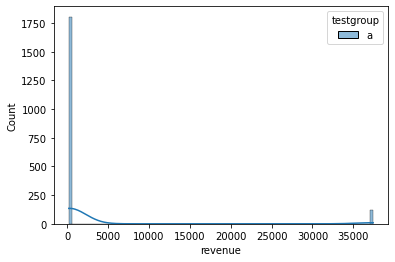

In [56]:
plt.figure
ax = sns.histplot(data=df_ab_test.query('revenue > 0 and testgroup == "a"'), 
                  x='revenue', 
                  hue='testgroup', 
                  kde=True, 
                  bins=100)

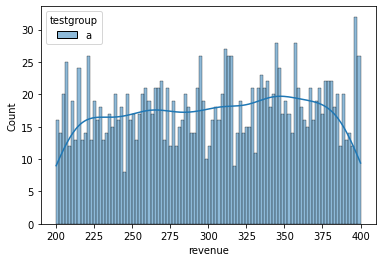

In [57]:
# Если убрать пользователей, которые потратили больше 35000, то распределение будет выглядеть получше. 
plt.figure
ax = sns.histplot(data=df_ab_test.query('revenue > 0 and revenue < 35000 and testgroup == "a"'), 
                  x='revenue', 
                  hue='testgroup', 
                  kde=True, 
                  bins=100)

In [58]:
# Но есди посмотреть на количество пользователей с тратами > 35000, их 1805
# Их оказывается достаточно много и вряд ли это можно считать за выброс
df_ab_test.query('revenue > 0 and revenue < 35000 and testgroup == "a"')['user_id'].count()

1805

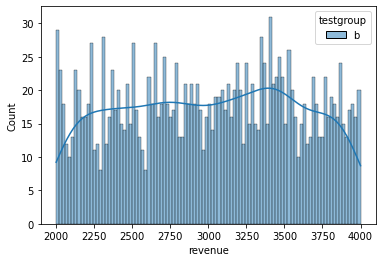

In [59]:
plt.figure
ax = sns.histplot(data=df_ab_test.query('revenue > 0 and testgroup == "b"'), 
                  x='revenue', 
                  hue='testgroup', 
                  kde=True, 
                  bins=100)

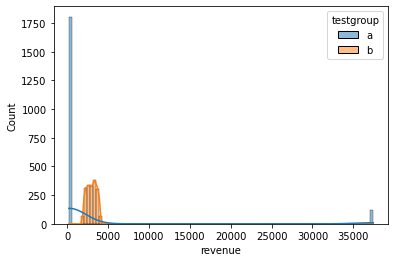

In [60]:
plt.figure
ax = sns.histplot(data=df_ab_test.query('revenue > 0'), 
                  x='revenue', 
                  hue='testgroup', 
                  kde=True, 
                  bins=100)

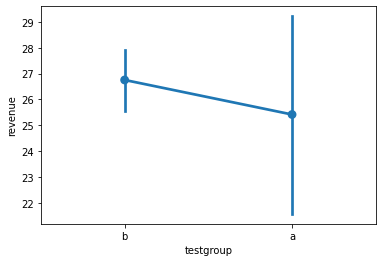

In [61]:
sns.pointplot(x = 'testgroup', y = 'revenue', data = df_ab_test)

На графиках видно, что в контрольной группе очень много пользователей с низкими затратами и очень много с крупными,что
не очень хорошо.
В тестовой группе ситуация получше, распределение походит на нормальное.

**Теперь посмотрю на p_value по каждой из метрик**

**Гипотезы:**
- H0 значимой разницы между группой a и b нет
- H1 значимая разница между группой a и b есть


Посмотрю на отличие в **CR** между группами.



Чтобы посмотреть различия в CR между контрольной и тестовой группой, необходимо создать колонку в основном ДатаФрейме с распределением, где 0 - это пользователь, который не потратил деньги, а 1 - пользователь, который потратил деньги.

In [62]:
df_ab_test['pay_or_not'] = df_ab_test.revenue.apply(lambda x: 1 if x != 0 else 0)

In [63]:
# Посмотрю, что колонка создалась
df_ab_test.head()

,user_id,revenue,testgroup,pay_or_not
0,1,0,b,0
1,2,0,a,0
2,3,0,a,0
3,4,0,b,0
4,5,0,b,0


In [64]:
# Посмотрю на данные в новой колонке, чтобы увидеть, что функция сработала
df_ab_test.pay_or_not.unique()

array([0, 1])

**Применю Тест Хи-Квадрат.**

**Тест хи-квадрат (χ²-тест)** — это статистический тест, который используется для проверки гипотез о распределении категориальных данных. Он позволяет определить, есть ли значительная разница между ожидаемыми и наблюдаемыми частотами в одной или нескольких категориях.

Условия применения теста хи-квадрат:
- Данные должны быть категориальными (например, пол, цвет, предпочтения).
- Наблюдаемые частоты должны быть достаточно большими. Обычно рекомендуется, чтобы ожидаемые частоты в каждой категории были не менее 5.
- Наблюдения должны быть независимыми.

Условия соблюдаются.

Тест выводит статистику хи-квадрат, p-значение, степени свободы и ожидаемые частоты.

In [65]:
chi_2_cr = stats.chi2_contingency(pd.crosstab(df_ab_test.testgroup, df_ab_test.pay_or_not))
chi_2_cr

(4.374729521260405,
 0.03647561892312613,
 1,
 array([[200239.10075104,   1863.89924896],
        [200797.89924896,   1869.10075104]]))

p_value = 0.03647561892312613

p_value < 0.05 

Это позволяет отклонить H0.

Значит, что различия между группами по Conversion Rate статистически значимы.

Теперь посмотрю на различия по метрике **ARPU**

Перед проведением теста, чтобы его выбрать, необходимо провести анализ на гомоскедантичность (равенство дисперсий между группами).

Воспользуюсь библиотекой pinguin и использую pg.homoscedasticity()

In [66]:
pg.homoscedasticity(data=df_ab_test, dv="revenue", group="testgroup")

,W,pval,equal_var
levene,0.389629,0.532495,True


Параметр equal_var указывает, следует ли предполагать равенство дисперсий при выполнении t-теста. Если equal_var=True, то используется стандартный t-тест. Если equal_var=False, то используется модифицированный t-тест (Welch's t-test), который не предполагает равенства дисперсий.

equal_var == True - Использую стандартный t-test


In [67]:
t_test_arpu = stats.ttest_ind(df_ab_test.query('testgroup == "a"').revenue, df_ab_test.query('testgroup == "b"').revenue)
t_test_arpu

Ttest_indResult(statistic=-0.6242026493616787, pvalue=0.532494858971837)

p_value = 0.532494858971837

p_value > 0.05 Не позволяет мне отклонить H0.

Это значит, что различия по ARPU между группами a и b НЕ ЯВЛЯЮТСЯ статистически значимыми. 

Теперь посмотрю на различия по метрике **ARPPU**

Аналогично проведу тест на равенство дисперсий между группами.

In [68]:
pg.homoscedasticity(data=df_ab_test.query('revenue >0'), dv="revenue", group="testgroup")

,W,pval,equal_var
levene,80.855674,3.779690e-19,False


equal_var == False - t_test использовать не могу, дисперсии не гомогенны.

Если дисперсии не равны, рекомендуется использовать тест Уэлча для сравнения средних значений двух групп или ANOVA Уэлча для более чем двух групп.

Воспользуюсь тестом Уэлча из библиотеки pinguin.


In [69]:
pg.welch_anova(data = df_ab_test.query('revenue >0'), dv = 'revenue', between = 'testgroup')

,Source,ddof1,ddof2,F,p-unc,np2
0,testgroup,1,1943.481522,2.704809,0.100208,0.000679


p_value = 0.100208

p_value > 0.05

Не отклоняю H0.

Это значит, что различия по ARPPU между группами a и b НЕ ЯВЛЯЮТСЯ статистически значимыми.

In [70]:
df_with_metrics

,all_users,revenue,paying_users,cr,arpu,arppu
testgroup,,,,,,
a,202103,5136189,1928,0.95%,25.413720,2663.998444
b,202667,5421603,1805,0.89%,26.751287,3003.658172


**Ответ на вопрос и вывод из проделланой мной работы.**

Данные по метрикам:

Группы были примерно равны

a = 202103 пользователей

b = 202667 пользователей

Сумма выручки была больше в тестовой группе:

a (revenue) = 5 136 189

b (revenue) = 5 421 603

По Conversion Rate различия между группами оказались статистически значимыми. 
Конверсия была больше в контрольной группе 
a (CR) = 0.95% 

b (CR) = 0.89%

По ARPU и ARPPU статистически значимых различий я не выявил.
Визуально по результатам подсчёта метрик, они тоже не сильно отличались.

a (ARPU) = 25.413720

b (ARPU) = 26.751287	

a (ARPPU) = 2663.998444

b (ARPPU) = 3003.658172


**Вывод:**

Хотелось бы оставить набор предложений, который использовался в контрольной группе.
Судя по полученным данным.
Но если ещё раз посмотреть на распределение дохода по группам на графике, видно, что у контрольной группы слишком много пользователей потратили маленькую сумму и есть выброс большого количества пользователей, которые потратили много.
Но сосчитав количество пользователей, которые потратили > 35000 (1805 пользователей), можно понять, что это вряд ли является выбросом.
Поэтому оставляем набор предложений, которые были в контрольной группе.

**Задание 3**

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как

### Для оценки результатов последнего прошедшего события в игре можно использовать следующие метрики:

**1. Количество игроков, участвовавших в событии, в процентном соотношении:**

Доля от общего числа активных игроков, которые приняли участие в событии.<br>
Для того, чтобы понять насколько удачной получилась идея внедреняя данного события в игру (как много игроков учавствовало в нём).

**2. Retention:**

Процент игроков, которые продолжили играть в игру после завершения события.<br>
Чтобы в дальнейшем понимать, стоит ли повторять подобное событие ещё раз.<br>
Упадёт ли спрос к игре после завершения события или же наоборот?<br>

**3. Процент игроков, завершивших событие:**

Доля участников события, которые успешно прошли все уровни и получили награду.

**4. Количество новых пользователей:**

Общее количество новых пользователей, зарегистрировавшихся в игре за время проведения события.<br>
Даст понять, сколько новых пользователей получилось заманить в нашу игру, благодоря событию.

**5. Среднее время прохождения события по каждому уровню/заданию и время в целом на всё событие**:

Сколько времени в среднем игроки потратили на прохождение события и уровней/заданий отдельно?<br>
Данная метрика сможет дать понять, какие уровни/задания стоит исключить или усложнить/облегчить.<br> Чтобы задержать или не отпугнуть игроков.

**6. Среднее количество пройденных уровней/заданий среди всех участвовавших игроков:**

Даст понимание и оценку сложности события в целом.

**7. Среднее количество попыток среди всех игроков на прохождение каждого уровня:**

Хорошо сработает в сочетании с пунктами 3,5 и 6 моего списка.<br> С помощью этих метрики можно будет делать выводы о том,<br> какие уровни/задания стоит усовершенствовать, исключить, добавить новые или например выявить баги и недостатки конкретного из них.

**8. Сумма выручки за период проведения события:**

Если в игре есть дополнительные предметы или внутриигровая валюта, которые можно приобрести за реальные деньги,<br> чтобы доставить большее удовольствие от игры или же обеспечить преимущество за счёт приобретённых предметов.<br> То можно внедрять спецальные предложения на время проведения события (предоставлять скидки, выпускать уникальные предметы,посвящённые событию и.т.п.).<br>
Уже потом провести анализ вырученных денег за проведение события.<br> Насколько больше пользователи потратили денег, чем в обычный период времени.

**9. Провести опрос:**

Насколько игроки удовлетворены событием, что им понравилось/не понравилось, хотели бы они повторения подобного рода мероприятия?

**Все эти метрики помогут оценить успешность события, выявить недостатки и позволит приянть решение о том, стоит ли проводить подобное событие повторно**


### Изменения метрик при усложнении механики игры

**1. Количество игроков, участвовавших в событии, в процентном соотношении:**

Количество игроков вероятнее ввсего снизиться. Сложность по практике в подобных играх отпугивают игроков.

**2. Retention:**

Может снизиться. Если усложнением будут недовльны. То игроки перестанут возвращаться в игру.

**3. Процент игроков, завершивших событие:**

Опять же, если сложность уровней/заданий будет слишком высока и пользовтелей будет часто откатывать на несколько уровней назад,<br>
то этот показатель тоже снизится, не все смогу пройти событие полностью.

**4. Количество новых пользователей:**

На данную метрику тоже может повлиять усложнение специфики/механики игры.<br>
Сарафанное радио сделает своё дело, люди перестанут советовать своим знакомым игру.

**5. Среднее время прохождения события по каждому уровню/заданию и время в целом на всё событие**:

Показатель увеличиться. Игроки из-за откатов будут дольше проходить уровни. НО! Вероятно это повлияет на траты пользователей.<br>
Об этом расскажу в пункте 8 моего текста.

**6. Среднее количество пройденных уровней/заданий среди всех участвовавших игроков:**

И снова скажу о том, что метрика скорее всего повлияет в худшую сторону, не все справятся, не все пройдут полностью.

**7. Среднее количество попыток среди всех игроков на прохождение каждого уровня:**

Метрика покажет рост, но нужно ли нам это?

**8. Сумма выручки за период проведения события:**

Данная метрика вероятнее всего покажет лучшие цифры. По сравнению с тем, если бы мы не усложняли механику игры.<br>
Пользователи станут тратить больше денег на дополнительные фичи, которые поспособствуют ускоренному прохождению уровней/заданий.

### Какие метрики можно будет использовать при внедрении изменений в механику игры?

**1. Среднее количество откатов на игрока.**

**2. Среднее количество попыток на завершение одного уровня.**

**3. Процент игроков, столкнувшихся с откатом (доля тех, кого откатило назад хотя бы один раз).**

**4. Процент игроков, которые перестали играть в игру после откатов.**

**5. Процент игроков, которые совершили покупку после откатов.**




 Судя по сделанным мною выводам, цена потери большинства пользователей может быть очень высока.<br>
 Мы вероятно потеряем игроков, которые просто напросто не справятся с заданиями и потеряют интерес к игре.<br>
 Хотя конечно, останутся  пользователи, заинтересованные игрой, которые будут и хотят тратить деньги, что принесёт нам прибыль.<br>
 Но это уже нужно оценивать исходя из AB теста, который стоит провести перед внедрением изменений в игру.<br>
 Сделать две группы, в одной изменений механики игры не будет, а в другой будет.<br>
 В дальнейшем уже можно будет принять решение о внедрении изменений.